<a href="https://colab.research.google.com/github/SHAHAB-UDDIN54/Artificial-intelligence-Ai-projects/blob/main/Step_by_Step_Grad_CAM_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1 — Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2  # for heatmap overlay
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model


Step 2 — Load Pretrained ModeL

In [2]:
# Load ResNet50 with ImageNet weights
model = ResNet50(weights="imagenet")


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Step 3 — Load and Prepare Image

In [5]:
# Load image (replace with your own image path)
# To upload an image: In the Colab sidebar, click on the 'Files' icon (folder icon),
# then click 'Upload to session storage' (file with up arrow icon) and select your image file.
# Once uploaded, replace 'your_image.jpg' with the actual filename (e.g., 'my_image.jpg').
img_path = "/content/IMG-20251020-WA0036.jpg"

# Load image and resize to 224x224
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))

# Convert image to array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Expand dimensions (model expects batch)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess image for ResNet
img_array = preprocess_input(img_array)

Step 4 — Create Grad Model

In [6]:
# Select last convolutional layer name
last_conv_layer_name = "conv5_block3_out"

# Create model that outputs:
# 1. Last conv layer output
# 2. Final predictions
grad_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)


Step 5 — Compute GradientS

In [7]:
# Use GradientTape to compute gradients
with tf.GradientTape() as tape:

    # Forward pass
    conv_outputs, predictions = grad_model(img_array)

    # Get predicted class index
    pred_index = tf.argmax(predictions[0])

    # Get prediction score for that class
    class_channel = predictions[:, pred_index]

# Compute gradient of class output wrt conv layer output
grads = tape.gradient(class_channel, conv_outputs)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Step 6 — Compute Importance Weights

In [8]:
# Global average pooling of gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


Step 7 — Create Heatmap

In [9]:
# Multiply each channel by importance weight
conv_outputs = conv_outputs[0]

heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Apply ReLU (only positive influence)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Convert to numpy
heatmap = heatmap.numpy()


Step 8 — Overlay Heatmap on Image

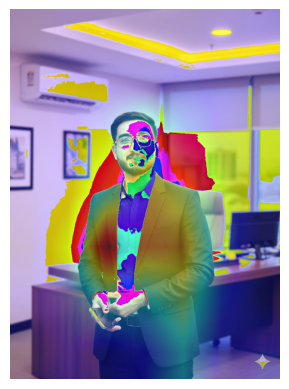

In [10]:
# Load original image (without preprocessing)
original_img = cv2.imread(img_path)

# Resize heatmap to image size
heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# Apply color map
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on original image
superimposed_img = heatmap * 0.4 + original_img

# Show result
plt.imshow(cv2.cvtColor(superimposed_img.astype("uint8"), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
